### Detecting body points

In [37]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

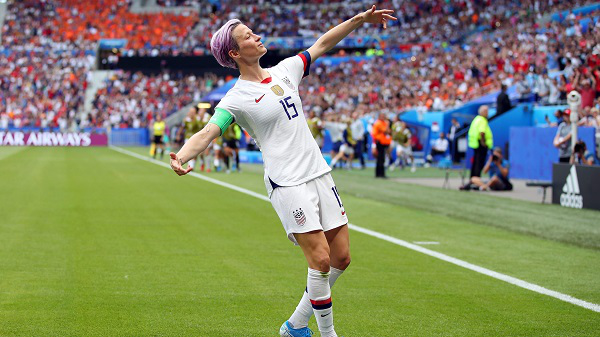

In [38]:
load_img("Images/megan.jpg")

In [39]:
image = cv2.imread("Images/megan.jpg")
type(image),image.shape

(numpy.ndarray, (337, 600, 3))

In [40]:
image_blob = cv2.dnn.blobFromImage(image=image,
                                   scalefactor = 1.0/255,
                                   size=(image.shape[1],
                                         image.shape[0]))

In [41]:
type(image_blob),image_blob.shape

(numpy.ndarray, (1, 3, 337, 600))

In [42]:
network = cv2.dnn.readNetFromCaffe("Weights/pose_deploy_linevec_faster_4_stages.prototxt",
                                   "Weights/pose_iter_160000.caffemodel")

In [43]:
len(network.getLayerNames())

127

In [44]:
network.setInput(image_blob)
output = network.forward()

In [45]:
output.shape

(1, 44, 43, 75)

In [46]:
position_width = output.shape[3]
position_height = output.shape[2]

In [47]:
num_points = 15
points = []
threshold = 0.1
for i in range(num_points):
    confidence_map = output[0,i,:,:]
    _,confidence,_,point = cv2.minMaxLoc(confidence_map)
#     print(confidence,point)
    x = int(image.shape[1]*point[0]/position_width)
    y = int(image.shape[0]*point[1]/position_height)
    if confidence>threshold:
        cv2.circle(image,(x,y),5,(0,255,0),thickness=-1)
        cv2.putText(image,f"{i}",(x,y),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,0,255))
        points.append((x,y))
    else:
        points.append(None)

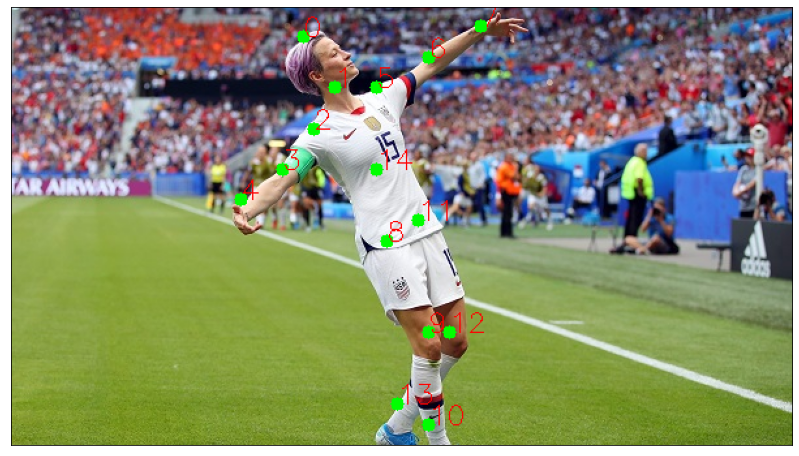

In [50]:
plt.figure(figsize=(14,10))
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.xticks(())
plt.yticks(())
plt.show()

In [51]:
point_connections = [[0,1],[1,2],[2,3],[3,4],
                     [1,5],[5,6],[6,7],[1,14],
                     [14,8],[8,9],[9,10],[14,11],
                     [11,12],[12,13]]

In [53]:
for connection in point_connections:
    part_a = connection[0]
    part_b = connection[1]
    if points[part_a] and points[part_b]:
        cv2.line(image,points[part_a],points[part_b],(255,0,0))

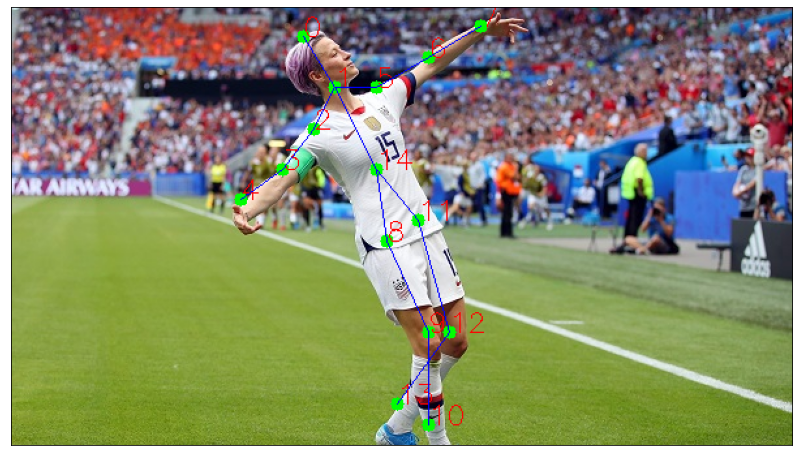

In [56]:
plt.figure(figsize=(14,10))
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.xticks(())
plt.yticks(())
plt.show()

### Detecting movements(arms above the head)

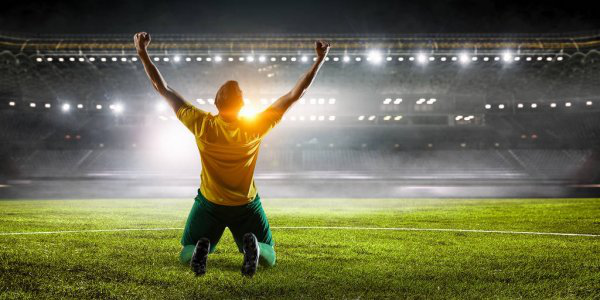

In [57]:
load_img("Images/player.jpg")

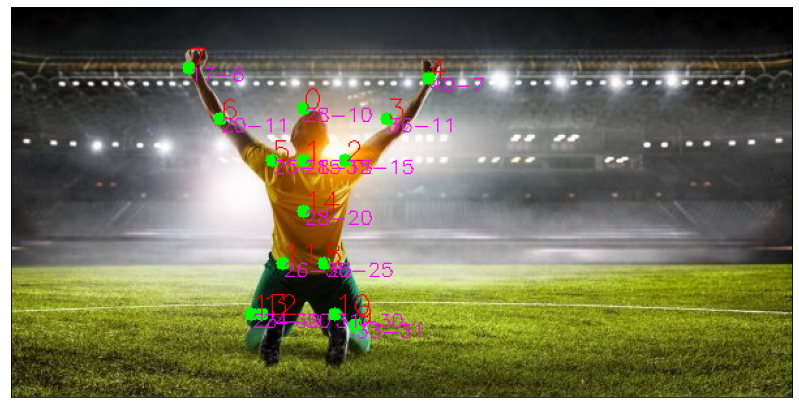

In [70]:
image_2 = cv2.imread("Images/player.jpg")
image_blob_2 = cv2.dnn.blobFromImage(image=image_2,
                                     scalefactor = 1.0/255,
                                     size=(image_2.shape[1],
                                           image_2.shape[0]))
network.setInput(image_blob_2)
output_2 = network.forward()
position_width = output_2.shape[3]
position_height = output_2.shape[2]
num_points = 15
points = []
threshold = 0.1
for i in range(num_points):
    confidence_map = output_2[0,i,:,:]
    _,confidence,_,point = cv2.minMaxLoc(confidence_map)
    x = int(image_2.shape[1]*point[0]/position_width)
    y = int(image_2.shape[0]*point[1]/position_height)
    if confidence>threshold:
        cv2.circle(image_2,(x,y),5,(0,255,0),thickness=-1)
        cv2.putText(image_2,f"{i}",(x,y),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,0,255))
        cv2.putText(image_2,f"{point[0]}-{point[1]}",(x,y+10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,255))
        points.append((x,y))
    else:
        points.append(None)
plt.figure(figsize=(14,10))
plt.imshow(cv2.cvtColor(image_2,cv2.COLOR_BGR2RGB))
plt.xticks(())
plt.yticks(())
plt.show()

In [139]:
def verify_arms_up(points):
    head,right_wrist,left_wrist = 0,0,0
    for i,point in enumerate(points):
        if i == 0:
            head = point[1]
        elif i == 4:
            right_wrist = point[1]
        elif i == 7:
            left_wrist = point[1]
    return right_wrist<head and left_wrist<head

In [140]:
verify_arms_up(points)

True

In [141]:
video = "Videos/gesture1.mp4"
capture = cv2.VideoCapture(video)
connected, frame = capture.read()
connected

True

In [142]:
result = "Videos/gesture1_result.mp4"
save_video = cv2.VideoWriter(result,cv2.VideoWriter_fourcc(*"XVID"),10,(frame.shape[1],frame.shape[0]))

In [143]:
threshold = 0.1
num_points = 15
while cv2.waitKey(1)<0:
    connected, frame = capture.read()
    if not connected:
        break
    image_blob = cv2.dnn.blobFromImage(image=frame,
                                       scalefactor = 1.0/255,
                                       size=(256,256))
    network.setInput(image_blob)
    output = network.forward()
    position_width = output.shape[3]
    position_height = output.shape[2]
    points = []
    for i in range(num_points):
        confidence_map = output[0,i,:,:]
        _,confidence,_,point = cv2.minMaxLoc(confidence_map)
        x = int(frame.shape[1]*point[0]/position_width)
        y = int(frame.shape[0]*point[1]/position_height)
        if confidence>threshold:
            cv2.circle(frame,(x,y),5,(0,255,0),thickness=-1)
            cv2.putText(frame,f"{i}",(x,y),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,0,255))
            cv2.putText(frame,f"{point[0]}-{point[1]}",(x,y+10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,255))
            points.append((x,y))
        else:
            points.append(None)
            
    for connection in point_connections:
        part_a = connection[0]
        part_b = connection[1]
        if points[part_a] and points[part_b]:
            cv2.line(frame,points[part_a],points[part_b],(255,0,0))
            
    if verify_arms_up(points):
        cv2.putText(frame,"Complete",(50,200),cv2.FONT_HERSHEY_SIMPLEX,3,(0,0,255))
    
    save_video.write(frame)
save_video.release()
print("END")

END
